In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal

In [5]:
def lpf2(x, alpha):
    y = np.zeros(len(x))
    y[0] = 0
    y[1] = 0
    for i in range(2,len(x)):
        y[i] = alpha**2*x[i] + 2*(1-alpha)*y[i-1] - (1-alpha)**2 * y[i-2]
    return y

def lpf_test(x):
    y = np.zeros(len(x))
    y[0] = 0
    y[1] = 0
    for i in range(2,len(x)):
        y[i] = 0.29289322*x[i] + 0.58578644*x[i-1] + 0.29289322*x[i-2] + 1.71572875e-01 * y[i-2]
    return y

def lpf_ba(x, b, a):
    y = np.zeros(len(x))
    order = len(b)
    y[0] = 0
    y[1] = 0
    for i in range(order,len(x)):
        for j in range(0,order):
            y[i] = y[i] + x[i-j]*b[j]
        for j in range(1,order):
            y[i] = y[i] - y[i-j]*a[j]
    return y

Text(0.5, 0, '$f/f_\\mathrm{Nyquist}$')

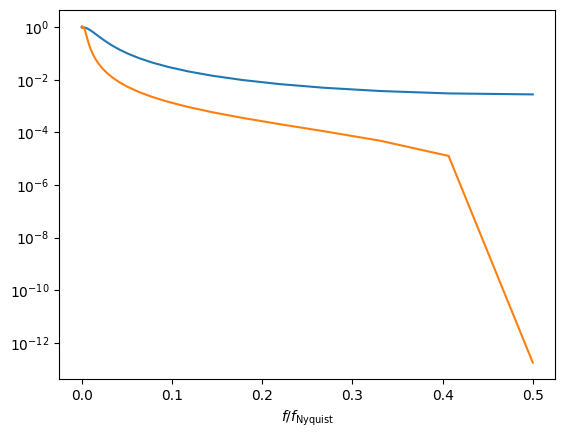

In [6]:
%matplotlib inline
NP = 50_000
ALPHA = 0.1

t = np.linspace(0,1, NP)

#b, a = scipy.signal.butter(4, 0.001)
b, a = scipy.signal.butter(2, 0.0075)

N=50
freqs = np.geomspace(1,NP/2,N)
resp, resp2 = np.zeros(N), np.zeros(N)
for i,f in enumerate(freqs):
    y = lpf2(np.sin(2*np.pi*f*t), ALPHA)
    resp[i] = np.sqrt(np.mean(y[len(y)//2::]**2))*np.sqrt(2)
    
    y = lpf_ba(np.sin(2*np.pi*f*t), b, a)
    resp2[i] = np.sqrt(np.mean(y[len(y)//2::]**2))*np.sqrt(2)
    
#def h(a, omega):
#    return a**2/np.sqrt(1+4*(1-a)**2+(1-a)**4 + 2*(-2*(1-a) + (1-a)**2 - 2*(1-a)**3)*np.cos(omega))
    
plt.semilogy(freqs/NP, resp)
plt.semilogy(freqs/NP, resp2)
#plt.semilogy(freqs/NP, h(ALPHA, freqs/NP))
plt.xlabel("$f/f_\\mathrm{Nyquist}$")

In [7]:
t = np.linspace(0,1,10_000)
y = np.cos(2*np.pi*t * 1000) + np.sin(2*np.pi*t * 8)

In [3]:
%matplotlib inline

b, a = scipy.signal.butter(2, 0.001)

plt.plot(t,y)
#plt.plot(t, scipy.signal.lfilter(b, a, y))
plt.plot(t,lpf_ba(y, b, a))
#plt.ylim(-2**14,2**14)

NameError: name 'scipy' is not defined

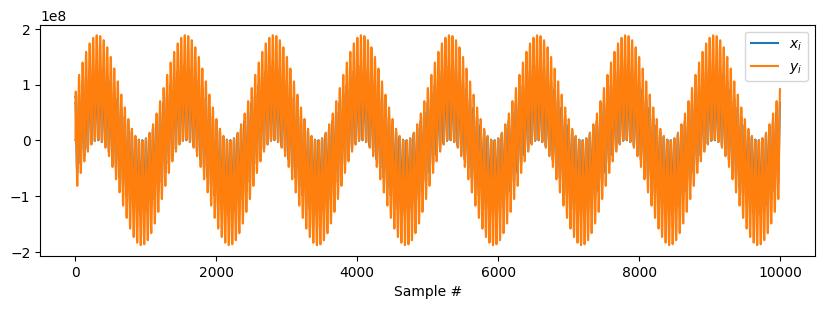

In [9]:
%matplotlib inline

plt.figure(figsize=(10,3))

t = np.linspace(0,1,10_000)
y = ((np.cos(2*np.pi*t * 200) + np.sin(2*np.pi*t * 8))*(2**26 - 1)).astype(int)

plt.plot(y, label='$x_i$')
#plt.plot(t, scipy.signal.lfilter(b, a, y))
plt.plot(lpf_test(y),label='$y_i$')
plt.legend()
#plt.ylim(-2**14,2**14)
plt.xlabel("Sample #")
plt.savefig("testFilter.svg", bbox_inches='tight')

In [10]:
n_bits = 18

b, a = scipy.signal.butter(2, 0.002)
print((b*2**n_bits).astype(int))
print((a*2**n_bits).astype(int))

[2 5 2]
[ 262144 -521958  259824]


In [11]:
def lpf_test(x):
    y = np.zeros(len(x)).astype(int)
    y[0] = 0
    y[1] = 0
    for i in range(2,len(x)):
        #print(5*x[i] + 10*x[i-1] + 5*x[i-2] - 399*y[i-1] + 164*y[i-2])
        y[i] = (3*x[i] + 7*x[i-1] + 3*x[i-2] + 32040*y[i-1]//2**14 - 15672*y[i-2]//2**14)
    return y//2**14


In [12]:
def lpf_ba_int(x, b_float, a_float, n_bits):
    a=(a_float*2**n_bits).astype(np.int64)
    b=(b_float*2**n_bits).astype(np.int64)
    
    
    y = np.zeros(len(x)).astype(np.int64)
    order = len(b)
    y[0] = 0
    y[1] = 0
    ymax = 0;
    for i in range(order,len(x)):
        for j in range(0,order):
            y[i] = y[i] + x[i-j]*b[j]
        for j in range(1,order):
            y[i] = y[i] - y[i-j]*a[j]//2**n_bits
            ymax = max(ymax, abs(y[i-j]*a[j]))
    print(ymax)
    return y//2**n_bits

def lpf_ba_int_arbprec(x, b_float, a_float, n_bits):
    a=(a_float*2**n_bits).astype(np.int64)
    b=(b_float*2**n_bits).astype(np.int64)
    
    print("Computation needs %d bits" % (np.ceil(np.max(np.log2(np.abs(a)))) + n_bits + np.ceil(np.log2(np.max(np.abs(x))))))
    
    order = len(b)
    y = [0]*order
    ymax = 0;
    for i in range(order,len(x)):
        y.append(0)
        for j in range(0, order):
            y[i] = y[i] + int(x[i-j])*int(b[j])
        for j in range(1,order):
            y[i] = y[i] - int(y[i-j])*int(a[j])//2**n_bits
            ymax = max(ymax, abs(int(y[i-j])*int(a[j])))
    print(ymax)
    for i in range(0,len(y)):
        y[i] = y[i] // 2**n_bits
    return y

def lpf_ba_int_arbprec_p(x, b_float, a_float, n_bits):
    a=(a_float*2**n_bits).astype(np.int64)
    b=(b_float*2**n_bits).astype(np.int64)
    
    print("Computation needs %d bits" % (np.ceil(np.max(np.log2(np.abs(a)))) + n_bits + np.ceil(np.log2(np.max(np.abs(x))))))
    
    order = len(b)
    y = [0]*len(x)
    ymax = 0;
    ac = [0]*len(a)
    bc = [0]*len(b)
    for i in range(order,len(x)-1):
        
        for j in range(1,order):
            y[i] = y[i] - ac[j]//2**n_bits
        for j in range(1, order):
            y[i] = y[i] + bc[j]
        y[i] = y[i] + b[0]*x[i]
        
        for j in range(0,order):
            ac[j] = int(y[i-j-1])*int(a[j])
        for j in range(1,order):
            bc[j] = int(x[i-j-1])*int(b[j])
    
    for i in range(0,len(y)):
        y[i] = y[i] // 2**n_bits
    return y

def lpf_test3(x):
    y = [0]*len(x)
    
    b1 = 0
    b2 = 0
    a1 = 0
    a2 = 0
    
    for i in range(2,len(x)-1):
        
        y[i] = 2*x[i] + b1 + b2 + (a1 + a2) // 2**20
        
        b1 = 5*x[i]
        b2 = 2*x[i-1]
        a1 = int(2092493)*int(y[i])
        a2 = int(-1043927)*int(y[i-1])
    
    for i in range(0,len(y)):
        y[i] = y[i] // 2**n_bits
    return y


In [13]:
lpf_test3(y)

[0,
 0,
 501,
 3246,
 8149,
 15089,
 23912,
 34440,
 46465,
 59758,
 74074,
 89150,
 104716,
 120495,
 136209,
 151583,
 166351,
 180259,
 193070,
 204566,
 214555,
 222872,
 229380,
 233976,
 236592,
 237193,
 235782,
 232397,
 227114,
 220040,
 211319,
 201124,
 189657,
 177145,
 163838,
 150003,
 135923,
 121890,
 108201,
 95154,
 83045,
 72159,
 62770,
 55137,
 49496,
 46059,
 45012,
 46510,
 50675,
 57596,
 67326,
 79881,
 95241,
 113351,
 134120,
 157425,
 183111,
 210994,
 240864,
 272491,
 305624,
 340000,
 375344,
 411377,
 447818,
 484389,
 520822,
 556860,
 592262,
 626809,
 660305,
 692581,
 723500,
 752955,
 780875,
 807223,
 831999,
 855239,
 877014,
 897430,
 916628,
 934777,
 952078,
 968754,
 985053,
 1001238,
 1017591,
 1034398,
 1051955,
 1070558,
 1090497,
 1112056,
 1135507,
 1161104,
 1189080,
 1219644,
 1252980,
 1289238,
 1328539,
 1370967,
 1416571,
 1465366,
 1517328,
 1572399,
 1630485,
 1691458,
 1755161,
 1821407,
 1889983,
 1960655,
 2033170,
 2107261,
 21

Computation needs 64 bits
6809053566704481576


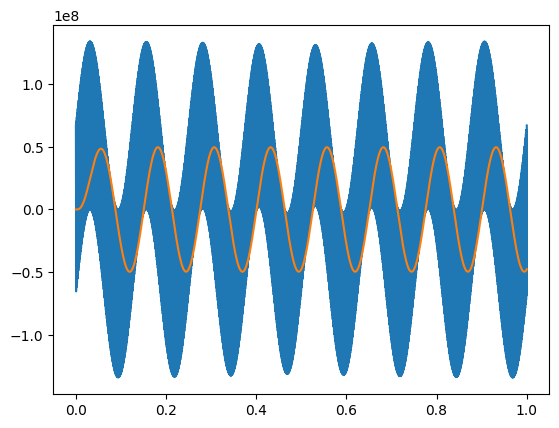

In [14]:
t = np.linspace(0,1,10_000)
y = ((np.cos(2*np.pi*t * 1000) + np.sin(2*np.pi*t * 8))*(2**26 - 1)).astype(int)

b, a = scipy.signal.butter(2, 0.002)

plt.plot(t,y)
plt.plot(t, lpf_ba_int_arbprec(y, b, a, 18))

#plt.plot(t, lpf_interleave(y))
#plt.plot(t,lpf_test(y))

In [15]:
n_bits = 20
b, a = scipy.signal.butter(2, 0.001)
print((b*2**n_bits).astype(int))
print((a*2**n_bits).astype(int))

[2 5 2]
[ 1048576 -2092493  1043927]


In [33]:
n_bits = 14

b, a = scipy.signal.butter(2, 0.01)
print((b*2**n_bits).astype(int))
print((a*2**n_bits).astype(int))

[3 7 3]
[ 16384 -32040  15672]


In [17]:
b,a

(array([0.00024136, 0.00048272, 0.00024136]),
 array([ 1.        , -1.95557824,  0.95654368]))

In [18]:
np.gcd(2092493,1043927)

1

In [19]:
np.log2(np.abs(a*2**n_bits))

array([14.        , 14.96759526, 13.93590275])

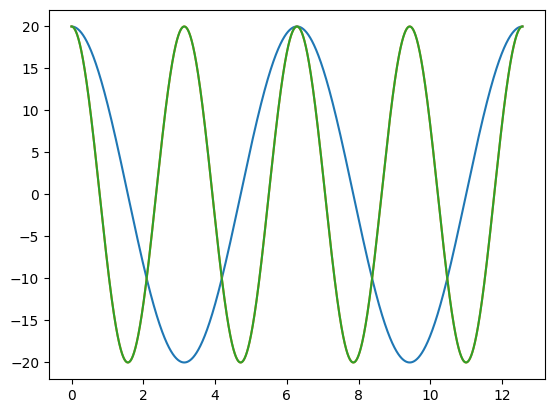

In [20]:
x = np.linspace(0,np.pi*4, 10_000)
A=20
y = A*np.cos(x)
y1 = A*np.cos(2*x)
y2 = 2*y*y/A  -A
plt.plot(x,y)
plt.plot(x,y1)
plt.plot(x,y2)

C:\Users\gilat\AppData\Local\Temp\ipykernel_14816\1876036496.py:79: RuntimeWarning: overflow encountered in long_scalars
  y[i] = 2*x[i] + b1 + b2 + (a1 + a2) // 2**20


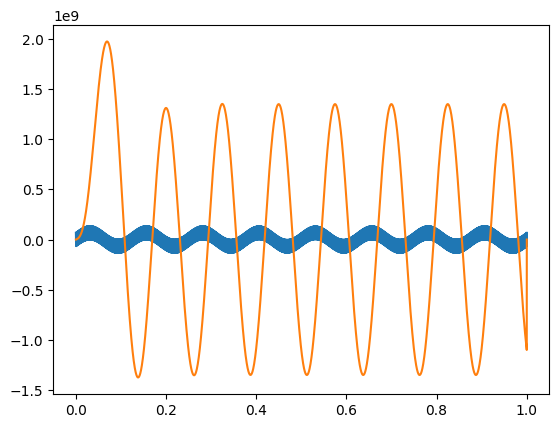

In [21]:
t = np.linspace(0,1,10_000)
y1 = ((np.cos(2*np.pi*t * 1000) + np.sin(2*np.pi*t * 8))*(2**26 - 1)).astype(int)
y2 = ((np.cos(2*np.pi*t*2 * 1000) + np.sin(2*np.pi*t/2 * 8))*(2**26 - 1)).astype(int)

b, a = scipy.signal.butter(2, 0.2)

plt.plot(t,y1)
#plt.plot(t, lpf_ba_int_arbprec_p(y, b, a, 4))
plt.plot(t, lpf_test3(y1))
#plt.plot(t,lpf_test(y))

In [22]:
def lpf_interleave(x):
    y1 = [0]*(len(x)//2)
    y2 = [0]*(len(x)//2)
    
    b0_1, b0_2 = 0, 0
    b1_1, b1_2 = 0, 0
    b2_1, b2_2 = 0, 0
    a1_1, a1_2 = 0, 0
    a2_1, a2_2 = 0, 0
    
    xi1_1, xi1_2 = 0, 0
    xi2_1, xi2_2 = 0, 0
    yi1_1, yi1_2 = 0, 0
    yi2_1, yi2_2 = 0, 0
    
    for i in range(2,len(x)-1):
        if(i%2 == 0):
            y1[i//2] = b0_1 + b1_1 + b2_1 + (a1_1 + a2_1) // 2**20
            
            b0_2 = 2*x[i+1]
            b1_1 = 5*x[i]
            b2_1 = 2*xi1_1
            a1_2 = int(2092493)*int(yi1_2)
            a2_1 = int(-1043927)*int(yi1_1)
            
            xi1_1 = x[i]
            yi1_1 = y1[i//2]
            
        if(i%2 == 1):
            y2[i//2] = b0_2 + b1_2 + b2_2 + (a1_2 + a2_2) // 2**20
            
            b0_1 = 2*x[i+1]
            b1_2 = 5*x[i]
            b2_2 = 2*xi1_2
            a1_1 = int(2092493)*int(yi1_1)
            a2_2 = int(-1043927)*int(yi1_2)
            
            xi1_2 = x[i]
            yi1_2 = y2[i//2]
    
    for i in range(0,len(y1)):
        y1[i] = y1[i] // 2**n_bits
    for i in range(0,len(y2)):
        y2[i] = y2[i] // 2**n_bits
    return y1, y2

def lpf_interleave2(x1, x2):
    y1 = [0]*len(x1)
    y2 = [0]*len(x1)
    
    b0_1, b0_2 = 0, 0
    b1_1, b1_2 = 0, 0
    b2_1, b2_2 = 0, 0
    a1_1, a1_2 = 0, 0
    a2_1, a2_2 = 0, 0
    
    xi1_1, xi1_2 = 0, 0
    xi2_1, xi2_2 = 0, 0
    yi1_1, yi1_2 = 0, 0
    yi2_1, yi2_2 = 0, 0
    
    clk = 0
    
    def module(xa, xb):
        if(clk):
            yo = 2*xa + b1_1 + b2_1 + (a1_1 + a2_1)//2**20
            
            b1_1 = 5*xa
            b2_1 = 2*xi1_1
            a1_2 = 2092493*xi1_2
            a2_1 = -1043927*xi1_1
        else:
            yo = 2*xb + b1_2 + b2_2 + (a1_2 + a2_2)//2**20
            
            b1_2 = 5*xb
            b2_2 = 2*xi1_2
            a1_1 = 2092493*xi1_1
            a2_2 = -1043927*xi1_2
        return yo
    for i in range(len(x1)):
        out = module(x1[i], x2[i])
        if(i%2==0):
            y1[i] = out
        else:
            y2[i] = out
    return y1,y2

C:\Users\gilat\AppData\Local\Temp\ipykernel_14816\871714292.py:30: RuntimeWarning: overflow encountered in long_scalars
  y2[i//2] = b0_2 + b1_2 + b2_2 + (a1_2 + a2_2) // 2**20
C:\Users\gilat\AppData\Local\Temp\ipykernel_14816\871714292.py:18: RuntimeWarning: overflow encountered in long_scalars
  y1[i//2] = b0_1 + b1_1 + b2_1 + (a1_1 + a2_1) // 2**20


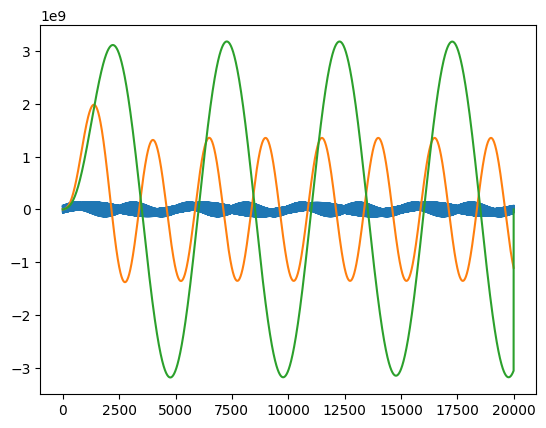

In [23]:
y1 = ((np.cos(2*np.pi*t * 1000) + np.sin(2*np.pi*t * 8))*(2**26 - 1)).astype(int)
y2 = ((np.cos(2*np.pi*t*2 * 1000) + np.sin(2*np.pi*t/2 * 8))*(2**26 - 1)).astype(int)

y_interleave = np.transpose([y1,y2]).flatten()

plt.plot(y_interleave)
y1, y2 = lpf_interleave(y_interleave)
# plt.plot(y1)
# plt.plot(y2)
# plt.plot(lpf_interleave(y1,y2))

plt.plot(np.arange(len(y1))*2,y1)
plt.plot(np.arange(len(y2))*2,y2)

In [24]:
def lpf_interleave_4x(x):
    y1 = [0]*(len(x)//4)
    y2 = [0]*(len(x)//4)
    y3 = [0]*(len(x)//4)
    y4 = [0]*(len(x)//4)
    
    b0_1, b0_2, b0_3, b0_4 = 0, 0, 0, 0
    b1_1, b1_2, b1_3, b1_4 = 0, 0, 0, 0
    b2_1, b2_2, b2_3, b2_4 = 0, 0, 0, 0
    a1_1, a1_2, a1_3, a1_4 = 0, 0, 0, 0
    a2_1, a2_2, a2_3, a2_4 = 0, 0, 0, 0
    
    xi1_1, xi1_2, xi1_3, xi1_4 = 0, 0, 0, 0
    xi2_1, xi2_2, xi2_3, xi2_4 = 0, 0, 0, 0
    yi1_1, yi1_2, yi1_3, yi1_4 = 0, 0, 0, 0
    yi2_1, yi2_2, yi2_3, yi2_4 = 0, 0, 0, 0
    
    for i in range(2,len(x)-2):
        if(i%4 == 0):
            y1[i//4] = b0_1 + b1_1 + b2_1 + (a1_1 + a2_1) // 2**20
            
            b0_3 = 2*x[i+2]
            b1_1 = 5*x[i]
            b2_1 = 2*xi1_1
            a1_3 = int(2092493)*int(yi1_3)
            a2_1 = int(-1043927)*int(yi1_1)
            
            xi1_1 = x[i]
            yi1_1 = y1[i//4]
            
        if(i%4 == 1):
            y2[i//4] = b0_2 + b1_2 + b2_2 + (a1_2 + a2_2) // 2**20
            
            b0_4 = 2*x[i+2]
            b1_2 = 5*x[i]
            b2_2 = 2*xi1_2
            a1_4 = int(2092493)*int(yi1_4)
            a2_2 = int(-1043927)*int(yi1_2)
            
            xi1_2 = x[i]
            yi1_2 = y2[i//4]
            
        if(i%4 == 2):
            y3[i//4] = b0_3 + b1_3 + b2_3 + (a1_3 + a2_3) // 2**20
            
            b0_1 = 2*x[i+2]
            b1_3 = 5*x[i]
            b2_3 = 2*xi1_3
            a1_1 = int(2092493)*int(yi1_1)
            a2_3 = int(-1043927)*int(yi1_3)
            
            xi1_3 = x[i]
            yi1_3 = y3[i//4]
            
        if(i%4 == 3):
            y4[i//4] = b0_4 + b1_4 + b2_4 + (a1_4 + a2_4) // 2**20
            
            b0_2 = 2*x[i+2]
            b1_4 = 5*x[i]
            b2_4 = 2*xi1_4
            a1_2 = int(2092493)*int(yi1_2)
            a2_4 = int(-1043927)*int(yi1_4)
            
            xi1_4 = x[i]
            yi1_4 = y4[i//4]
    
    for i in range(0,len(y1)):
        y1[i] = y1[i] // 2**20
    for i in range(0,len(y2)):
        y2[i] = y2[i] // 2**20
    for i in range(0,len(y3)):
        y3[i] = y3[i] // 2**20
    for i in range(0,len(y4)):
        y4[i] = y4[i] // 2**20
    return y1, y2, y3, y4

C:\Users\gilat\AppData\Local\Temp\ipykernel_14816\583424517.py:32: RuntimeWarning: overflow encountered in long_scalars
  y2[i//4] = b0_2 + b1_2 + b2_2 + (a1_2 + a2_2) // 2**20
C:\Users\gilat\AppData\Local\Temp\ipykernel_14816\583424517.py:44: RuntimeWarning: overflow encountered in long_scalars
  y3[i//4] = b0_3 + b1_3 + b2_3 + (a1_3 + a2_3) // 2**20
C:\Users\gilat\AppData\Local\Temp\ipykernel_14816\583424517.py:56: RuntimeWarning: overflow encountered in long_scalars
  y4[i//4] = b0_4 + b1_4 + b2_4 + (a1_4 + a2_4) // 2**20


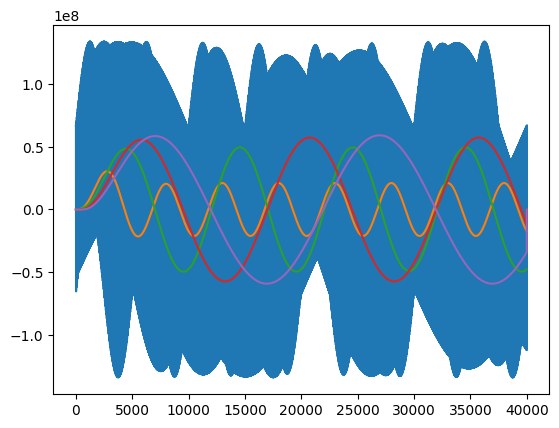

In [25]:
y1 = ((np.cos(2*np.pi*t * 1000) + np.sin(2*np.pi*t * 8))*(2**26 - 1)).astype(int)
y2 = ((np.cos(2*np.pi*t*2 * 1000) + np.sin(2*np.pi*t/2 * 8))*(2**26 - 1)).astype(int)
y3 = ((np.cos(2*np.pi*t*2 * 1000) + np.sin(2*np.pi*t/3 * 8))*(2**26 - 1)).astype(int)
y4 = ((np.cos(2*np.pi*t*2 * 1000) + np.sin(2*np.pi*t/4 * 8))*(2**26 - 1)).astype(int)

y_interleave = np.transpose([y1,y2,y3,y4]).flatten()

plt.plot(y_interleave)
y1, y2, y3, y4 = lpf_interleave_4x(y_interleave)
plt.plot(np.arange(len(y1))*4,y1)
plt.plot(np.arange(len(y2))*4,y2)
plt.plot(np.arange(len(y3))*4,y3)
plt.plot(np.arange(len(y4))*4,y4)

In [26]:
def coeffTest(x, b0, b1, a1, B0, B1, A1):
    y = np.zeros(len(x))
    z = np.zeros(len(x))
    for i in range(1,len(x)):
        y[i] = B0*x[i] + B1*x[i-1] - A1*y[i-1]
    for i in range(1,len(x)):
        z[i] = b0*y[i] + b1*y[i-1] - a1*z[i-1]
        
    return z

def coeffTest2(x, b0, b1, a1, B0, B1, A1):
    y = np.zeros(len(x))
    for i in range(1,len(x)):
        y[i] = B0*b0*x[i] + (b0*B1 + b1*B0)*x[i-1] + b1*B1*x[i-2] - (a1+A1)*y[i-1] - a1*A1*y[i-2]
    return y

In [27]:
t = np.linspace(0,1,10_000)
y = np.cos(2*np.pi*t * 1000) + np.sin(2*np.pi*t * 8)

In [28]:
%matplotlib widget
plt.plot(t, y)
plt.plot(t, coeffTest(y, 0.5, 0.1, 0.5, 0.5, 0.1, 0.5))
plt.plot(t, coeffTest2(y, 0.5, 0.1, 0.5, 0.5, 0.1, 0.5))

ModuleNotFoundError: No module named 'ipympl'